# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [2]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.

Nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [3]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:


$$tsh \in(\,40, \,60\,)$$

$$(1) \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$

$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$

$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$

$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [1]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

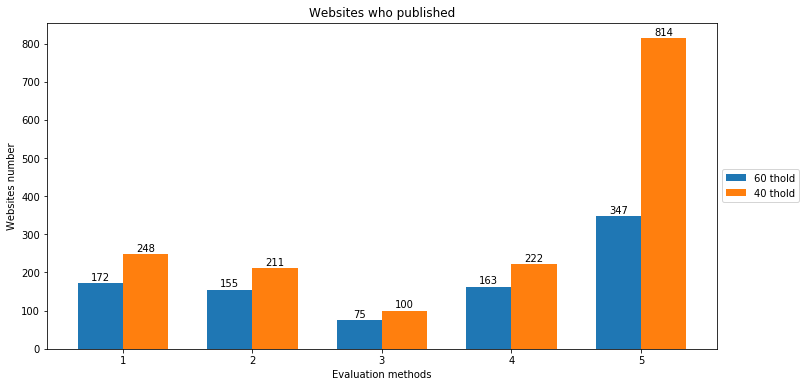

In [5]:
i = 0
generate_plot(i, stp)
plt.show()

### Percentuale siti con pubblicazioni

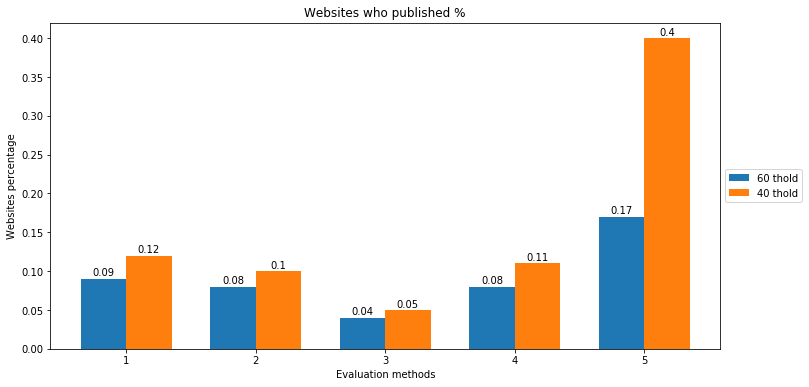

In [6]:
i = 1
generate_plot(i, stp)
plt.show()

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

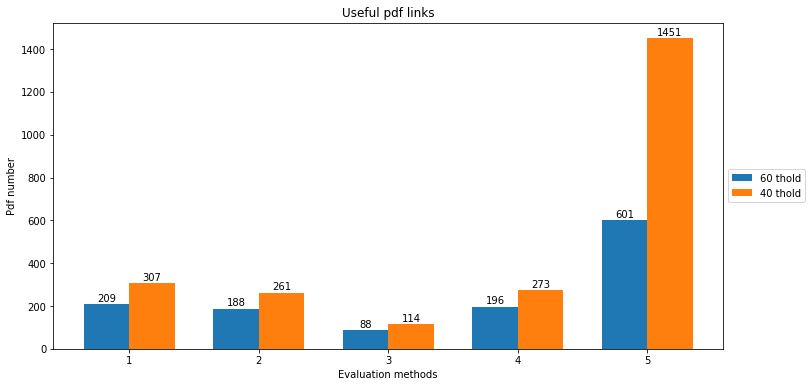

In [7]:
i = 2
generate_plot(i, stp)
plt.show()

### Percentuale di file pdf utili

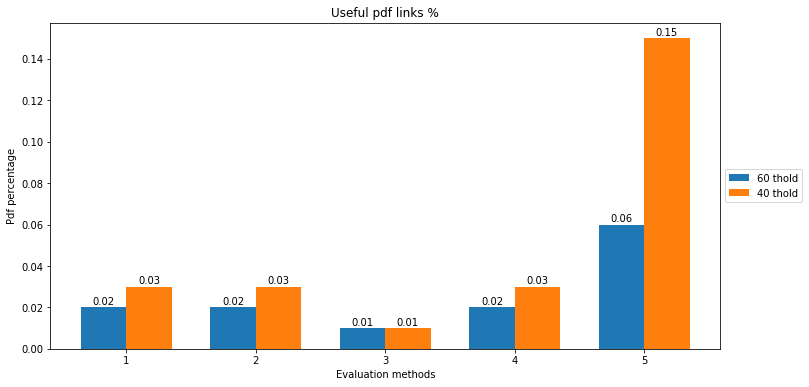

In [8]:
i = 3
generate_plot(i, stp)
plt.show()

### Profondità media dei file

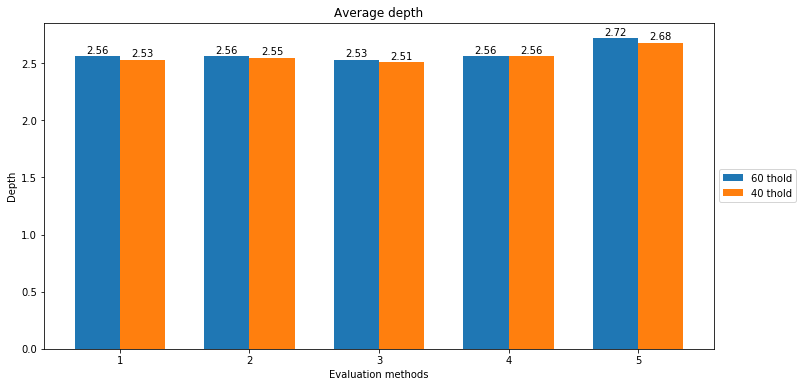

In [9]:
i = 4
generate_plot(i, stp)
plt.show()

### Numero di link presenti in homepage

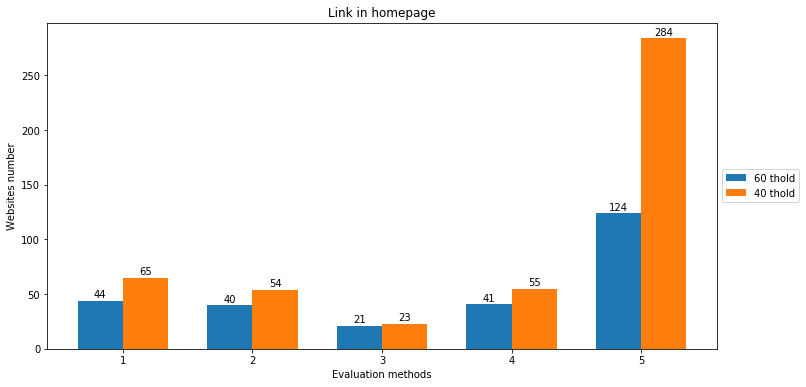

In [10]:
i = 5
generate_plot(i, stp)
plt.show()

# File processing

Dopo aver ottenuto la lista di link ( è stata utilizzata la lista ottenuta dalla prima condizione tra quelle testate, essendo quella che tiene in considerazione più file ) i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [11]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,307
1,file to process,239
2,file processed,218


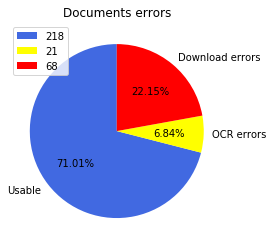

In [12]:
labels = 'Usable', 'OCR errors', 'Download errors'
val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'r']

fig1, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
ax.set_title("Documents errors")
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

La popolazione dell'indice si basa su richieste alle API Atoka e Dandelion.
È possibile che alcuni report siano stati pubblicati da aziende le cui informazioni non sono completamente reperibili tramite Atoka, ci sono quindi alcuni documenti elastic incompleti, che presentano ad esempio la mancanza dell'indirizzo dell'azienda, del codice ateco, dei ricavi o del numero di dipendenti.

Companies in index: 170


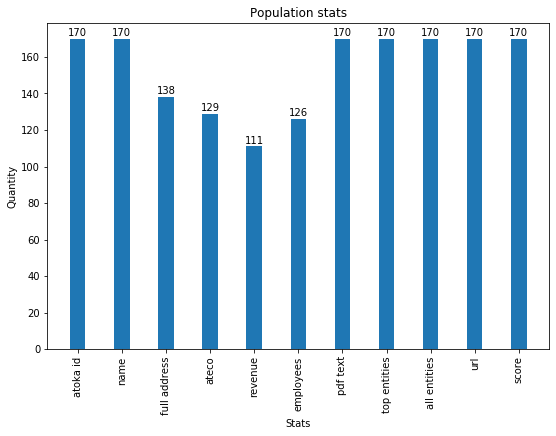

In [13]:
from elasticsearch_utilities import generate_plot

stats_path = "elasticsearch_utilities/stats/population.csv"
generate_plot(stats_path)
print("Companies in index: 170")
plt.show()

# Analisi: Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, che quelle principali.

# Modelli su tutte le entità

Il numero di entità presente per ogni documento è abbastanza alto, in media sono presenti __2496__ entità.

È stato creato un modello con l'insieme completo di entità, senza alcun vincolo, poi sono stati considerati dei vincoli di frequenza tra documenti e all'interno di un singolo documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta vicoli sulle keyword, si cercano quindi i topics considerando la lista completa di entità estratte dal testo.

### Preprocessing
Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. _dtm_tf_ : frequency vector
2. _tf_vectorizer_ : count vectorizer contentente il vocabolario estratto dai documenti

In [14]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Secret_Intelligence_Service no Open_Systems_In...
1,2,Sustainability History Scientific_research Sus...
2,3,Board_of_Directors economy Quality_of_life Com...
3,4,Rosia_Montana Value_added Recycling circular_E...
4,5,Financial_statements Product_(economics) Work ...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [2]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 24646 

Words:

'secret_intelligence_service' : 19536
'open_systems_interconnection' : 15581
'galactic_standard_calendar' : 8997
'autonomous_province_of_trento' : 2103
'natural_resource' : 14809
'gender_' : 9138
'social_sciences' : 20243
'technology' : 21568
'vita' : 23724
'environment_' : 7377
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

### Parametri 
Nella creazione del modello bisogna tenere conto del numero di argomenti da trovare e di due parametri alpha e beta.

I valori di __alpha__ e __beta__ controllano rispettivamente:
1. quanti topics fanno parte di un documento: per un valore basso si assume che ogni documento sia composto da pochi topics 
2. quante parole compongono ogni topic: un valore più basso fa assumere al modello che ogni topic sia composto da poche keyword specifiche.
    
Per il primo caso, non avendo restrizioni sulla frequenza nei documenti e avendo tutte le entità per ogni testo, si assume che:
1. i topics presenti siano tanti
2. i testi siano composti da non troppi topics rispetto al totale 
3. ogni topic usi un sottoinsieme non troppo grande della totalità delle keyword nel vocabolario 

In [5]:
%%capture
from sklearn.decomposition import LatentDirichletAllocation

#topics = 9
#alpha = 0.005
#beta = 0.00001

topics = 14
alpha = 0.01
beta =  0.01

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)

### Visualizzazione

I topics trovati sono visualizzati con pyLDAvis.

In [6]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.138335  0.000167       1        1  21.730454
7     -0.204806 -0.032567       2        1  19.129065
11    -0.171307  0.033298       3        1  13.027080
5      0.186680 -0.035043       4        1   8.065584
10    -0.180982 -0.021055       5        1   6.531035
4      0.147668 -0.052774       6        1   6.274287
0     -0.231446  0.030873       7        1   6.226668
8     -0.232358  0.086773       8        1   4.180875
13     0.231338  0.078021       9        1   4.062511
3      0.274099  0.132051      10        1   3.045540
6     -0.203665 -0.196082      11        1   2.420760
9     -0.222322  0.112193      12        1   2.020688
12     0.222540 -0.044684      13        1   1.901096
2      0.246224 -0.091174      14        1   1.384358, topic_info=             Term        Freq       Total Category  logprob  loglift
47   environment_   61.000000   61.000000  Default  30.0000  30.0000
6         biology   61.000000   61.000000  Default  29.0000  29.0000
143      society_   53.000000   53.000000  Default  28.0000  28.0000
144     sociology   53.000000   53.000000  Default  27.0000  27.0000
8        business  109.000000  109.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
51         ethics    1.001469   71.747527  Topic14  -4.0633   0.0082
74    information    1.001469   55.819566  Topic14  -4.0633   0.2593
40        economy    1.001469   66.723099  Topic14  -4.0633   0.0809
46         energy    1.001469   49.887055  Topic14  -4.0633   0.3716
156    technology    1.001469   46.848958  Topic14  -4.0633   0.4345

[608 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         2  0.240950   accounting
0         6  0.240950   accounting
0        12  0.481899   accounting
1         1  0.099263  agriculture
1         4  0.496313  agriculture
...     ...       ...          ...
174       3  0.071615        world
174       6  0.143230        world
174       7  0.214845        world
174      10  0.107422        world
174      12  0.035807        world

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 12, 6, 11, 5, 1, 9, 14, 4, 7, 10, 13, 3])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue sono stati impostati dei vincoli di frequenza, un' entità viene considerata a patto che:
1. compaia in almeno __N__ documenti distinti
2. compaia almeno __M__ volte all'interno di un documento

L'obiettivo è quello di scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio e quei termini secondari all'interno di un documento.

### Grandezza vocabolario

A seguire la grandezza del vocabolario in relazione ai valori __N__ ed __M__.

Tenendo presente che:
- il totale dei documenti è di _170_.
- il numero medio di entità trovate in un testo è di _2496_

si può notare che anche valori molto piccoli di N ed M riducono di molto la grandezza del vocabolario.

Il grafico non presenta l'andamento completo, ma solo la parte iniziale in cui si nota un decremento esponenziale della dimensione.

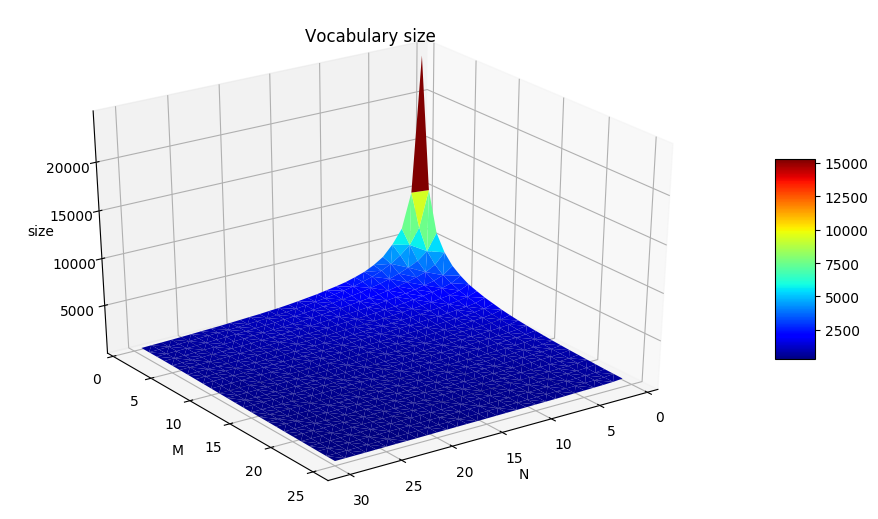

In [3]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

### Modello

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le __restrizioni__ discusse sopra.

Avendo una restrizione sulla frequenza, è opportuno cambiare i parametri del modello, in particolare:
1. si cercano __meno topics__, poichè con il vincolo di frequenza si eliminano gli argomenti troppo specifici per ogni documento
2. i documenti saranno __composti da più topics__ sul totale rispetto al caso precedente
3. non cambia la grandezza di ogni topic

A seguire il modello che considera solo i termini presenti in almeno il __25%__ dei __documenti__ e presenti almeno __15__ volte all'interno di un singolo documento.

Cambiando i paramentri del modello e includendo il constraint sulla frequenza si possono notare topic più distinti.

In [109]:
from lda_topic_model import preprocess_freq_count

N = round(170 * 0.25)
M = 15

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 9
alpha = 0.1
beta = 0.2
lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 296 

Words:

'environment_' : 82
'biology' : 11
'scientific_research' : 230
'sustainability' : 261
'sustainable_development' : 262
'stakeholder' : 252
'quality' : 202
'safety' : 223
'homo_sapiens' : 120
'innovation' : 133
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.195219  0.051879       1        1  21.987677
5     -0.249651 -0.016968       2        1  19.175136
6     -0.189307 -0.059999       3        1  18.692093
4      0.206655  0.148374       4        1  14.902309
1     -0.100289 -0.279071       5        1  11.805604
0      0.192727 -0.177465       6        1   5.261106
2      0.229782  0.069400       7        1   2.819851
8      0.284300  0.002951       8        1   2.773520
3     -0.178997  0.260899       9        1   2.582702, topic_info=                       Term         Freq        Total Category  logprob  \
261          sustainability  9354.000000  9354.000000  Default  30.0000   
89                     euro  2341.000000  2341.000000  Default  29.0000   
78               employment  7658.000000  7658.000000  Default  28.0000   
39                  company  4986.000000  4986.000000  Default  27.0000   
292                    work  2028.000000  2028.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
270                    tool     7.094316   249.509500   Topic9  -6.2728   
7                     audit    29.913816  1131.264520   Topic9  -4.8338   
179  packaging_and_labeling    18.296956   771.399710   Topic9  -5.3254   
32           climate_change    12.881881   490.889742   Topic9  -5.6763   
96                  finance    14.288182  1106.139584   Topic9  -5.5727   

     loglift  
261  30.0000  
89   29.0000  
78   28.0000  
39   27.0000  
292  26.0000  
..       ...  
270   0.0961  
7     0.0236  
179  -0.0851  
32    0.0159  
96   -0.6929  

[464 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         5  0.917490    accounting
0         8  0.076458    accounting
1         6  0.933964        africa
2         4  0.992990   agriculture
2         6  0.005796   agriculture
...     ...       ...           ...
292       6  0.121767          work
292       7  0.024649          work
292       8  0.073948          work
294       3  0.978569  working_time
295       7  0.938907         world

[781 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 7, 5, 2, 1, 3, 9, 4])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di entità principali.

La lista di entità questa volta non contiene doppioni, si può pensare alle entità principali come a un set ordinato per importanza, cambierà quindi il criterio di frequenza, essendo il precedente inapplicabile nella parte di conteggio delle occorrenze all'interno di ogni documento.  

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei modelli più specifici.

Anche in questo caso è inizialmente considerato l'insieme totale di entità e successivamente quello ristretto per il nuovo principio di frequenza.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà. Bisogna però tenere presente che il numero medio di entità principali per ogni testo è di 250, molto minore di 2496, ottenuto come media del numero di entità complete.

In [143]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")
print_vocab(tf_vectorizer.vocabulary_)


Total words in vocabulary : 10271 

Words:

'secret_intelligence_service' : 8168
'open_systems_interconnection' : 6405
'galactic_standard_calendar' : 3686
'autonomous_province_of_trento' : 785
'natural_resource' : 6082
'gender_' : 3744
'social_sciences' : 8462
'technology' : 9039
'vita' : 9899
'environment_' : 2973
...


Per la scelta dei parametri nel modello, si è __ridotto__ il numero di __topics__, __aumentando__ i valori di __alpha__ e __beta__ rispetto al modello su tutte le entità.

In [117]:
topics = 13
alpha = 0.03
beta =  0.01

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.189191  0.097577       1        1  20.143242
11    -0.204195  0.009228       2        1  14.863987
5     -0.240084  0.073146       3        1  11.710164
6     -0.215017 -0.005137       4        1  11.591445
4      0.251108  0.027866       5        1   9.884637
1     -0.160390 -0.244836       6        1   6.950436
12    -0.244378 -0.107397       7        1   6.109478
0      0.128438 -0.238786       8        1   4.198328
9      0.313333  0.047945       9        1   3.967531
2      0.200137 -0.017147      10        1   3.221360
3     -0.079165  0.301290      11        1   3.004549
8      0.240598 -0.094860      12        1   2.897020
10     0.198807  0.151112      13        1   1.457821, topic_info=               Term         Freq        Total Category  logprob  loglift
261  sustainability  9422.000000  9422.000000  Default  30.0000  30.0000
78       employment  7649.000000  7649.000000  Default  29.0000  29.0000
292            work  2039.000000  2039.000000  Default  28.0000  28.0000
89             euro  2365.000000  2365.000000  Default  27.0000  27.0000
82     environment_  1744.000000  1744.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
131     information     0.009954  1814.329096  Topic13 -12.2700  -7.8850
157      management     0.009930  3334.399063  Topic13 -12.2724  -8.4960
96          finance     0.009930  1111.257577  Topic13 -12.2724  -7.3972
93          factory     0.009930    50.408205  Topic13 -12.2724  -4.3041
94           family     0.009930    76.854625  Topic13 -12.2724  -4.7259

[611 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         6  0.590420    accounting
0         7  0.335300    accounting
0        13  0.076536    accounting
1         8  0.995880        africa
2         9  1.000302   agriculture
...     ...       ...           ...
292      13  0.148073          work
293       2  0.989502     workforce
294       2  0.293972  working_time
294       4  0.702266  working_time
295      10  1.011276         world

[963 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 12, 6, 7, 5, 2, 13, 1, 10, 3, 4, 9, 11])

## Modello con vincoli di frequenza - entità principali

Il criterio per il vincolo di frequenza cambia: 
1. N rimane lo stesso, ovvero specifica la presenza in documenti distinti di una entità.
2. M questa volta diventa la quantità di entità considerate per ogni documento. Un paramentro piccolo indicherà la considerazione delle parole più importanti, mentre un paramentro alto comprenderà una quantità di parole, meno importanti, più elevata.

Per quanto riguarda la restrizione di frequenza interdocumento, ovvero sul parametro N, l'andamento della curva decresce in modo esponenziale, in linea con la curva nell'esempio precedente.

Per quanto riguarda il paramentro M, questa volta porta ad un incremento lineare del vocabolario, poichè ad ogni step si include un numero proporzionale al totale del numero di documenti.

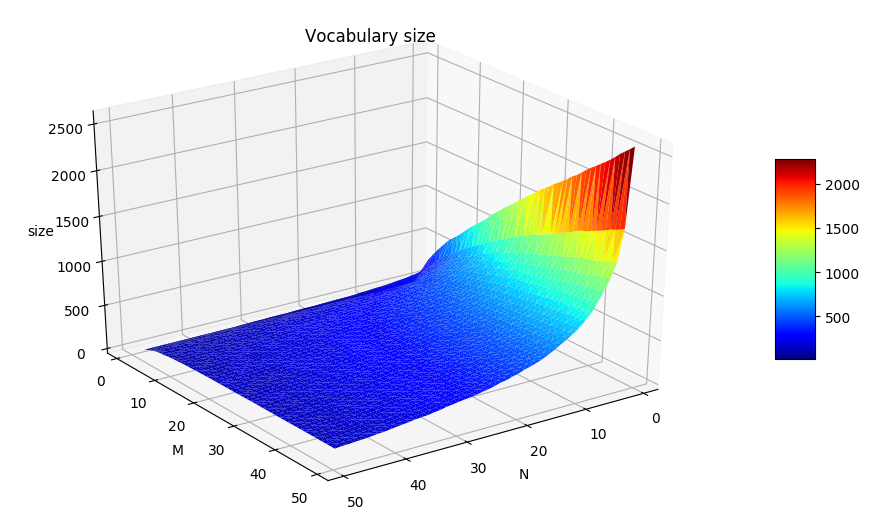

In [5]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path, en="top")
plt.show()

Il modelli che seguono mantengono la restrizione della frequenza adottata in precedenza per quanto riguarda N, ovvero si considerano i termini presenti nel 25% dei docuemnti, mentre per M si usano 50 e 30 rispettivamente.

### M = 50

In [8]:
from lda_topic_model import preprocess_freq_count_relevant

topics = 10
alpha = 0.7
beta = 0.1
lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)

N = round(170 * 0.25)
M = 50

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 175 

Words:

'natural_resource' : 99
'technology' : 156
'environment_' : 47
'biology' : 6
'territory' : 157
'water' : 169
'economical_progress' : 38
'policy' : 109
'work' : 172
'management' : 88
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.180905  0.003500       1        1  16.607195
8     -0.221558 -0.009887       2        1  16.471672
7     -0.188021 -0.119767       3        1  12.533375
0     -0.218130 -0.055435       4        1  10.405208
4      0.050879 -0.084828       5        1  10.154585
6     -0.201775  0.058801       6        1   9.397863
5      0.230780 -0.031025       7        1   8.426559
3      0.119281  0.011851       8        1   5.891031
2      0.237347 -0.078579       9        1   5.448268
9      0.010292  0.305369      10        1   4.664244, topic_info=                  Term       Freq      Total Category  logprob  loglift
52                euro  45.000000  45.000000  Default  30.0000  30.0000
27         corporation  56.000000  56.000000  Default  29.0000  29.0000
40             economy  74.000000  74.000000  Default  28.0000  28.0000
29             culture  44.000000  44.000000  Default  27.0000  27.0000
163          transport  27.000000  27.000000  Default  26.0000  26.0000
..                 ...        ...        ...      ...      ...      ...
95         methodology   0.139148  14.586888  Topic10  -7.2517  -1.5871
119       raw_material   0.139147  28.527294  Topic10  -7.2517  -2.2578
14               child   0.139144   8.233778  Topic10  -7.2517  -1.0152
135  scientific_method   0.139143  14.535106  Topic10  -7.2517  -1.5836
71        human_rights   0.139142  23.992694  Topic10  -7.2518  -2.0848

[424 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         4  0.818533     accounting
1         7  0.933725    agriculture
2         3  0.954227  air_pollution
3         2  0.941200          audit
4         1  0.196726       behavior
...     ...       ...            ...
172       9  0.133300           work
173       2  0.903440      workforce
174       1  0.218189          world
174       4  0.327284          world
174       5  0.436378          world

[509 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 8, 1, 5, 7, 6, 4, 3, 10])

### M = 30

In [7]:
topics = 8
alpha = 0.8
beta = 0.1
lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)

N = round(170 * 0.25)
M = 30

dtm_tf, tf_vectorizer = preprocess_freq_count_relevant("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 174 

Words:

'natural_resource' : 99
'technology' : 156
'environment_' : 47
'biology' : 6
'territory' : 157
'water' : 168
'economical_progress' : 38
'policy' : 109
'work' : 171
'management' : 88
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.236222 -0.056190       1        1  26.349963
3      0.187337  0.094039       2        1  15.199111
2      0.172487  0.043387       3        1  12.323129
0     -0.004585 -0.029587       4        1  10.342758
1     -0.246155 -0.149540       5        1   9.819598
7      0.126589 -0.119806       6        1   8.892976
4      0.163523 -0.075575       7        1   8.853514
5     -0.162974  0.293271       8        1   8.218951, topic_info=                Term       Freq      Total Category  logprob  loglift
58           finance  36.000000  36.000000  Default  30.0000  30.0000
27       corporation  35.000000  35.000000  Default  29.0000  29.0000
18         community  51.000000  51.000000  Default  28.0000  28.0000
144        sociology  43.000000  43.000000  Default  27.0000  27.0000
143         society_  43.000000  43.000000  Default  26.0000  26.0000
..               ...        ...        ...      ...      ...      ...
162         training   1.343518  24.286726   Topic8  -5.1177  -0.3959
19           company   2.762938  65.160838   Topic8  -4.3967  -0.6618
8           business   2.272156  64.289723   Topic8  -4.5922  -0.8439
40           economy   0.329027  54.952209   Topic8  -6.5246  -2.6194
70   human_resources   0.172059  11.860604   Topic8  -7.1729  -1.7344

[329 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         7  0.679116     accounting
1         6  0.844120    agriculture
2         1  0.824605  air_pollution
2         4  0.091623  air_pollution
2         6  0.091623  air_pollution
...     ...       ...            ...
171       7  0.023684           work
173       1  0.059295          world
173       2  0.237182          world
173       4  0.533659          world
173       7  0.177886          world

[343 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 3, 1, 2, 8, 5, 6])